In [1]:
# Notes from exploring in database:
# applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection job seems always have roughly the same number of calls per Auto Order Detection job run -
# I think this indicates that it is not the number of these jobs being called each time for detection that varies the total detection time but the length
# of each of these applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection jobs. I see around 1375 of these jobs per parent auto order detection
# job.

#Below SQL used to find total time for all applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection per main Auto Order Detection job.
#It suggests that a large part of the variation in the main Auto Order Detection time job is usually caused by the total of these
#applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection jobs:
#select execution_moniker, sum(DATEDIFF(ss, execution_start_timestamp,execution_end_timestamp))
#from APE_Execution_Queue (nolock)
#where execution_moniker='applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection'
#group by job_execution_guid, execution_moniker

#Below SQl to detect total execution time for all applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection grouped by BU that can be seen in the QJV
#at time of running:
#select org_hierarchy_id, execution_moniker, sum(DATEDIFF(ss, execution_start_timestamp,execution_end_timestamp))
#from APE_Execution_Queue (nolock)
#where execution_moniker='applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection'
#group by org_hierarchy_id, execution_moniker
#order by sum(DATEDIFF(ss, execution_start_timestamp,execution_end_timestamp)) desc

# see file in AO_Detection_Individual_BU_task_JS_code in path C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\Crystal Ball 2024 for
# the code that the applications.Inventory.ape.tasks.SCM_IM_BU_AutoOrderDetection task calls.

#I think the variable strDCAODetectionFlag in moniker Applications.Inventory.ape.tasks.SCM_IM_AutoOrderAGG  is not 'y' according to the below sql
#script:
#DECLARE   @offset int
#SET       @offset = DATEDIFF(hh, getdate(), getutcdate())
##IF# @dc_ao_detection_flag != 'y' #THEN#
#SELECT    DATEADD(hh, @offset, inv_autoorder_last_execution_timestamp )  AS execution_start_timestamp
##ELSE#
#SELECT    DATEADD(hh, @offset, inv_dc_autoorder_last_execution_timestamp )  AS execution_start_timestamp
##ENDIF#
#FROM      inventory_client_parameters
#WHERE     client_id = 1000101

#Sum of individual BU AO detection by hour query:
#select DATEADD(hh,datepart(hh, execution_queued_timestamp),convert(datetime,CONVERT(varchar(10), execution_queued_timestamp,121),121)) as datehour, execution_moniker, sum(DATEDIFF(ss, execution_start_timestamp,execution_end_timestamp)) as execution_time
#from APE_Execution_Queue (nolock)
#where execution_moniker='applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection'
#group by DATEADD(hh,datepart(hh, execution_queued_timestamp),convert(datetime,CONVERT(varchar(10), execution_queued_timestamp,121),121)), execution_moniker
#order by DATEADD(hh,datepart(hh, execution_queued_timestamp),convert(datetime,CONVERT(varchar(10), execution_queued_timestamp,121),121)) desc

#Main AO detection job by hour query:
#select DATEADD(hh,datepart(hh, execution_queued_timestamp),convert(datetime,CONVERT(varchar(10), execution_queued_timestamp,121),121)) as datehour, DATEDIFF(ss, execution_start_timestamp,execution_end_timestamp) as execution_time
#from APE_Execution_Queue (nolock)
#where execution_moniker='Applications.Inventory.ape.jobs.SCM_IM_BU_AutoOrderAGG'
#order by DATEADD(hh,datepart(hh, execution_queued_timestamp),convert(datetime,CONVERT(varchar(10), execution_queued_timestamp,121),121)) desc

In [2]:
"""
To schedule daily - number of APE jobs on A34V server by hour in the first 30 minutes of every hour:

create table #datehour (datehour smalldatetime);

with datecte as
(
SELECT DATEADD(hh, -1, DATEDIFF(dd, 0, getdate())) as datehour
UNION ALL
SELECT dateadd(hour,-1, datehour)
from datecte
where dateadd(hour,-1, datehour) > dateadd(hour,-360, DATEADD(hh, -1, DATEDIFF(dd, 0, getdate())))
)
insert into #datehour
select * from datecte
OPTION(MAXRECURSION 400)

select dh.datehour, count(dh.datehour)
from APE_Execution_Queue aeq(nolock)
right join #datehour dh
on dh.datehour between DATEADD(hh,datepart(hh, aeq.execution_start_timestamp),DATEADD(mi,datepart(mi, aeq.execution_start_timestamp)/10*10,convert(datetime,CONVERT(varchar(10), aeq.execution_start_timestamp,121),121))) and aeq.execution_end_timestamp
or DATEADD(mi, 10, dh.datehour) between DATEADD(hh,datepart(hh, aeq.execution_start_timestamp),DATEADD(mi,datepart(mi, aeq.execution_start_timestamp)/10*10,convert(datetime,CONVERT(varchar(10), aeq.execution_start_timestamp,121),121))) and aeq.execution_end_timestamp
or DATEADD(mi, 20, dh.datehour) between DATEADD(hh,datepart(hh, aeq.execution_start_timestamp),DATEADD(mi,datepart(mi, aeq.execution_start_timestamp)/10*10,convert(datetime,CONVERT(varchar(10), aeq.execution_start_timestamp,121),121))) and aeq.execution_end_timestamp
where execution_end_timestamp>DATEADD(dd,-1,convert(datetime,CONVERT(varchar(10), getdate(),121),121)) and host_name='SL1BPEPRDA34V'
group by dh.datehour
order by dh.datehour

drop table #datehour;
"""

"\nTo schedule daily - number of APE jobs on A34V server by hour in the first 30 minutes of every hour:\n\ncreate table #datehour (datehour smalldatetime);\n\nwith datecte as\n(\nSELECT DATEADD(hh, -1, DATEDIFF(dd, 0, getdate())) as datehour\nUNION ALL\nSELECT dateadd(hour,-1, datehour)\nfrom datecte\nwhere dateadd(hour,-1, datehour) > dateadd(hour,-360, DATEADD(hh, -1, DATEDIFF(dd, 0, getdate())))\n)\ninsert into #datehour\nselect * from datecte\nOPTION(MAXRECURSION 400)\n\nselect dh.datehour, count(dh.datehour)\nfrom APE_Execution_Queue aeq(nolock)\nright join #datehour dh\non dh.datehour between DATEADD(hh,datepart(hh, aeq.execution_start_timestamp),DATEADD(mi,datepart(mi, aeq.execution_start_timestamp)/10*10,convert(datetime,CONVERT(varchar(10), aeq.execution_start_timestamp,121),121))) and aeq.execution_end_timestamp\nor DATEADD(mi, 10, dh.datehour) between DATEADD(hh,datepart(hh, aeq.execution_start_timestamp),DATEADD(mi,datepart(mi, aeq.execution_start_timestamp)/10*10,convert(d

In [3]:
#For each hour, count the total number of rows for the first query - doesn't seem to be correlated to this, I tested against a time where the
#detection job took much longer to complete and the total number of rows returned for first query with all sites is the same.
#For each hour, count the total number of rows inserted,updated,deleted (number of rows for whole AO detection SQL script).
#Analyze CPU data because apparently this can increase the detection time - is the CPU data a rolling window with different window lengths and is the
#sum column the result of the observed (unrounded) times the count?
#Perhaps shift the Load data by 1 or a few hours to the left or right and perform correlation analysis again - shift by 1 seems to improve correlation
#a small amount.
#Number of rows selected/manipulated seems to be the same for all hours of a single day for the same BU so maybe review whole AO code again in case
#I missed some part.
#The APE Queue seems to suggest that the detection time isn't the cause for the majority of the difference in time for the main AO job when comparing a
#busy time against a non-busy time on January 13th 2025.
#It seems like it could be the moniker applications.inventory.ape.jobs.SCM_IM_Process_Transactions_AutoOrder.
#Why is the sum of the individual applications.inventory.ape.jobs.SCM_IM_BU_AutoOrderDetection jobs sometimes larger than the parent job
#Applications.Inventory.ape.jobs.SCM_IM_BU_AutoOrderAGG? Is it because more threads/more servers with the relevant segment were added? I think so because if multiple of same job running at a
#the main job time will be lower than if each job ran sequentially.
#So I think I need to add CPU/Load data from multiple servers, number of servers running the individual BU jobs.
#Predictive Power Score
#Distance Correlation
#Number of jobs running on A34V by hour.
#To set up:
#Collection of expected number of AOs.
#Collection of total APE jobs per hour on A34V.
#Collection of total time for all BU level jobs (summed) because I believe this is what indicates when additional thread(s) should be added and this
#time seems to have stronger correlation with CPU compared to AGG job.

In [4]:
#self defined distance correlation function
def dist_corr(df):
    cols = df.columns
    idx = cols.copy()
    K = len(cols)
    correl = np.empty((K, K), dtype=float)
    mat = df.to_numpy(dtype=float, na_value=np.nan, copy=False)
    mat = mat.T
    for i, ac in enumerate(mat):
        for j, bc in enumerate(mat):
            if i > j:
                continue
            if i == j:
                c = 1.0
            else:
                c = distance_correlation(ac, bc)
            correl[i, j] = c
            correl[j, i] = c
    dist_corr_df = pd.DataFrame(correl,index=idx,columns=cols)
    return dist_corr_df

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.dist_dependence_measures import distance_correlation
import ppscore as pps

filepath = r'C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\AO Detection Time Forecasting\AOTA_DE_PROD.csv'
data = pd.read_csv(filepath, index_col='datehour')
data.index = pd.to_datetime(data.index,format='%d/%m/%Y %H:%M')
data = data[:-168] #separate a week for data for validation.
print(data.shape)

(3600, 4)


In [6]:
data.tail(20)

,detection_time,order_time,actual_orders,no_of_items
datehour,,,,
2024-11-13 04:00:00,40.0,14.0,154,12755
2024-11-13 05:00:00,35.0,5.0,116,2305
2024-11-13 06:00:00,34.0,8.0,68,5172
2024-11-13 07:00:00,38.0,10.0,216,12712
2024-11-13 08:00:00,43.0,11.0,163,11469
2024-11-13 09:00:00,43.0,9.0,237,6273
2024-11-13 10:00:00,41.0,9.0,127,6297
2024-11-13 11:00:00,40.0,11.0,196,12739
2024-11-13 12:00:00,39.0,16.0,158,20279


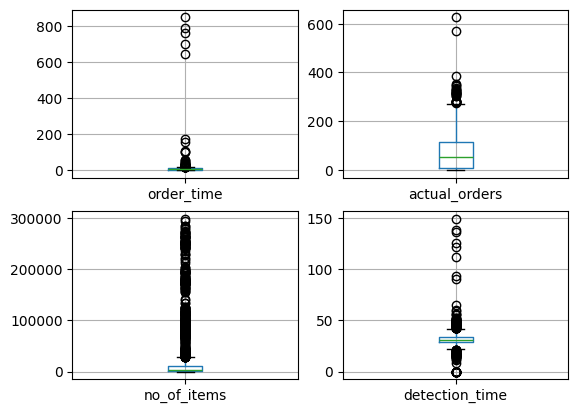

In [7]:
plt.subplot(2, 2, 1)
data.boxplot(column=['order_time'])

plt.subplot(2, 2, 2)
data.boxplot(column=['actual_orders'])

plt.subplot(2, 2, 3)
data.boxplot(column=['no_of_items'])

plt.subplot(2, 2, 4)
data.boxplot(column=['detection_time'])

plt.show()

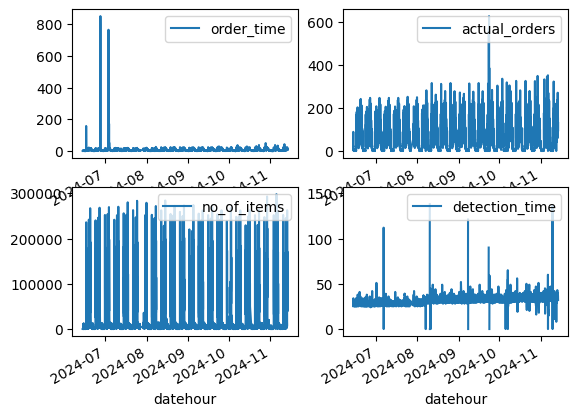

In [8]:
#these line graphs seems to clarify (with the use of the box plots) whether each of the four columns has outliers, high variance or both.
#seems like the maximum number of orders increased in August and increased again in October - check this with numbers and stationarity.
plt.subplot(2, 2, 1)
data['order_time'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
data['actual_orders'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 3)
data['no_of_items'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 4)
data['detection_time'].plot.line()
plt.legend(loc="upper right")

plt.show()

**Trying out some different outlier detections methods**

In [9]:
# calculate IQR for variable order_time
Q1 = data['order_time'].quantile(0.25)
Q3 = data['order_time'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# identify outliers via IQR
threshold = 1.5
outliers = data[(data['order_time'] < Q1 - threshold * IQR) | (data['order_time'] > Q3 + threshold * IQR)]
print(outliers)

6.0
                     detection_time  order_time  actual_orders  no_of_items
datehour                                                                   
2024-06-16 16:00:00            27.0       158.0            182       235870
2024-06-16 17:00:00            27.0        98.0            120        97362
2024-06-18 16:00:00            32.0        22.0            188       241771
2024-06-19 16:00:00            28.0        19.0            242       266991
2024-06-20 04:00:00            31.0        18.0            138        11567
...                             ...         ...            ...          ...
2024-11-11 12:00:00            14.0        19.0            172        15995
2024-11-11 15:00:00            14.0        43.0             85         7813
2024-11-12 16:00:00            32.0        23.0            221       245381
2024-11-13 16:00:00            35.0        24.0            271       262545
2024-11-13 20:00:00            33.0        18.0            158       170898

[136 ro

In [10]:
# identify outliers via standard deviation - this seems to be more appropriate
mean = np.mean(data['order_time'])
std = np.std(data['order_time'])
print('mean of the dataset is', mean)
print('std. deviation is', std)
threshold = 3
outliers = data[abs(data['order_time'] - mean)/std > threshold]
print('outlier in dataset is\n', outliers)

mean of the dataset is 7.133890008638065
std. deviation is 29.279527665661046
outlier in dataset is
                      detection_time  order_time  actual_orders  no_of_items
datehour                                                                   
2024-06-16 16:00:00            27.0       158.0            182       235870
2024-06-16 17:00:00            27.0        98.0            120        97362
2024-06-27 07:00:00            31.0       852.0            220        14247
2024-06-27 08:00:00            32.0       791.0            137        10184
2024-07-03 08:00:00            33.0       766.0            130        10409
2024-07-03 09:00:00            35.0       704.0            233         5890
2024-07-03 10:00:00            33.0       647.0            122         6747
2024-07-03 18:00:00            28.0       172.0            119        78986
2024-09-23 09:00:00             NaN       102.0              0            0
2024-09-23 12:00:00             NaN       108.0              0 

In [11]:
# drop outliers using standard deviation method
data.drop(data[abs(data['order_time'] - mean)/std > threshold].index, inplace=True)
print(data)

                     detection_time  order_time  actual_orders  no_of_items
datehour                                                                   
2024-06-14 00:00:00            26.0         1.0             12          332
2024-06-14 01:00:00            25.0         2.0             41          639
2024-06-14 02:00:00            26.0         3.0             21          491
2024-06-14 03:00:00            26.0         3.0             89         1320
2024-06-14 04:00:00            34.0         2.0             21          347
...                             ...         ...            ...          ...
2024-11-13 19:00:00            32.0         9.0            150        45497
2024-11-13 20:00:00            33.0        18.0            158       170898
2024-11-13 21:00:00            37.0         8.0            154        39254
2024-11-13 22:00:00            33.0        11.0             92        95094
2024-11-13 23:00:00            32.0         7.0            130        45469

[3590 rows 

In [12]:
# apply similar to actual_orders
mean = np.mean(data['actual_orders'])
std = np.std(data['actual_orders'])
print('mean of the dataset is', mean)
print('std. deviation is', std)
threshold = 4
outliers = data[abs(data['actual_orders'] - mean)/std > threshold]
print('outlier in dataset is\n', outliers)
data.drop(data[abs(data['actual_orders'] - mean)/std > threshold].index, inplace=True)
print(data.shape)

mean of the dataset is 68.22646239554318
std. deviation is 67.97504639243432
outlier in dataset is
                      detection_time  order_time  actual_orders  no_of_items
datehour                                                                   
2024-09-23 06:00:00           149.0         NaN            570       132889
2024-09-23 10:00:00           125.0         NaN            627       141834
2024-09-23 14:00:00            93.0         NaN            386       211202
2024-10-29 16:00:00            32.0        26.0            349       293028
2024-11-05 16:00:00            35.0        26.0            346       298085
2024-11-06 09:00:00            60.0         NaN            352        24914
(3584, 4)


In [13]:
# apply similar to detection_time
mean = np.mean(data['detection_time'])
std = np.std(data['detection_time'])
print('mean of the dataset is', mean)
print('std. deviation is', std)
threshold = 4
outliers = data[abs(data['detection_time'] - mean)/std > threshold]
print('outlier in dataset is\n', outliers)
data.drop(data[abs(data['detection_time'] - mean)/std > threshold].index, inplace=True)
print(data.shape)

mean of the dataset is 31.66974272930649
std. deviation is 6.2866590698425595
outlier in dataset is
                      detection_time  order_time  actual_orders  no_of_items
datehour                                                                   
2024-07-06 18:00:00           112.0         NaN              0            0
2024-07-06 19:00:00             0.0         NaN              0            0
2024-08-07 01:00:00             0.0         0.0              0            0
2024-08-07 02:00:00             0.0         0.0              0            0
2024-08-07 03:00:00             0.0         0.0              0            0
2024-08-07 04:00:00             0.0         0.0              0            0
2024-08-07 05:00:00             0.0         0.0              0            0
2024-08-07 06:00:00             0.0         0.0              0            0
2024-08-10 05:00:00           138.0         NaN              0            0
2024-08-10 07:00:00             0.0         0.0              0 

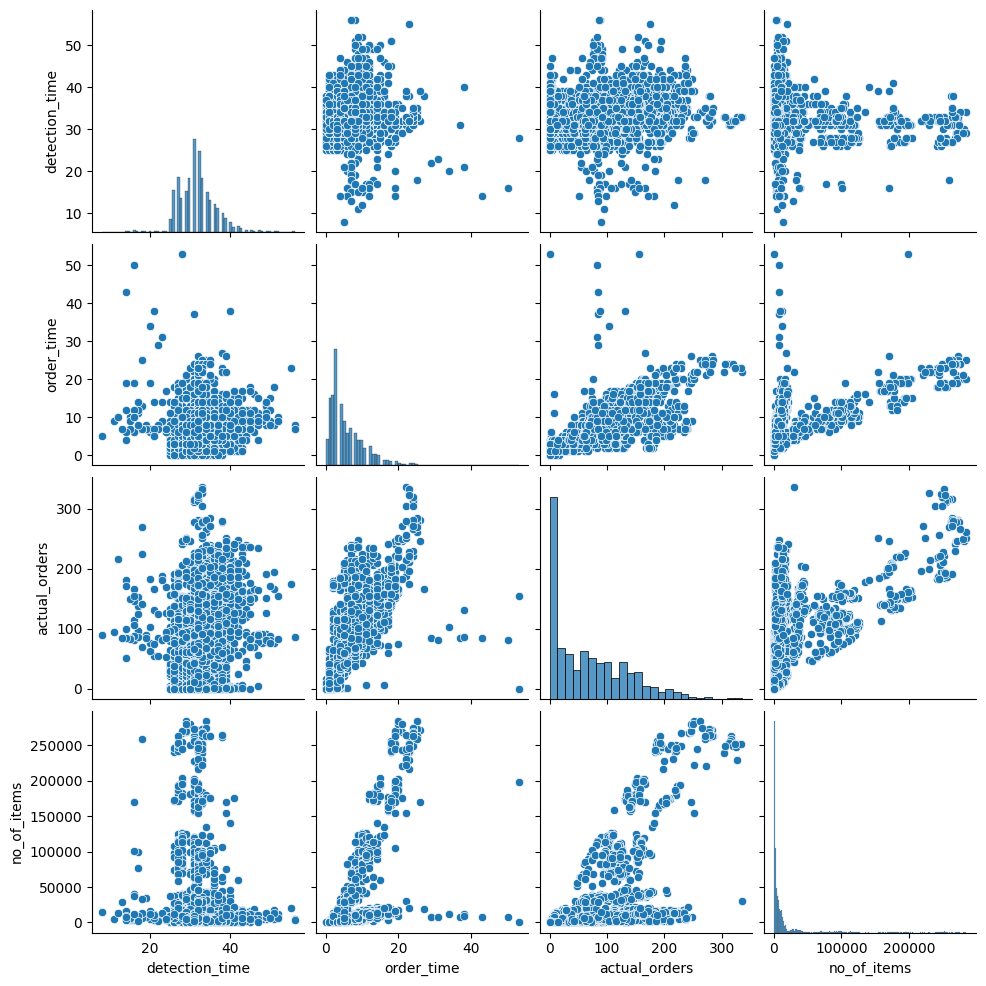

In [14]:
sns.pairplot(data)

In [15]:
corr_matrix = data.corr()
print(corr_matrix)

                detection_time  order_time  actual_orders  no_of_items
detection_time        1.000000    0.152313       0.207975    -0.052652
order_time            0.152313    1.000000       0.755492     0.639901
actual_orders         0.207975    0.755492       1.000000     0.546271
no_of_items          -0.052652    0.639901       0.546271     1.000000


                detection_time  order_time  actual_orders  no_of_items
detection_time        1.000000    0.358856       0.348199    -0.063359
order_time            0.358856    1.000000       0.794601     0.573403
actual_orders         0.348199    0.794601       1.000000     0.481368
no_of_items          -0.063359    0.573403       0.481368     1.000000


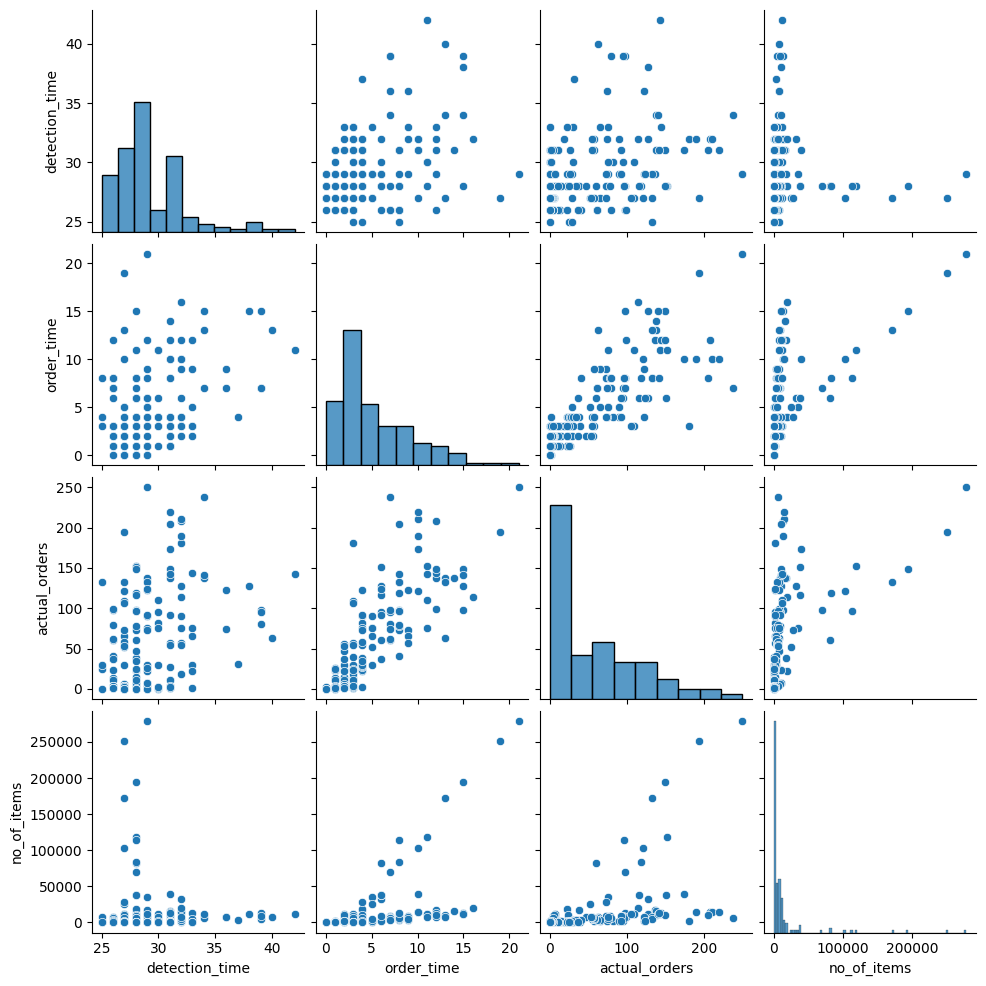

In [16]:
#plotting shorter period of the data
corr_matrix_period = data[1000:1168].corr()
print(corr_matrix_period)
sns.pairplot(data[1000:1168])

In [17]:
#detection_time against no_of_items seems to be similar to equation y=abs(1/x).
print(data['detection_time'].corr(abs(1/data['no_of_items']))) #I think this print doesn't seem to work because the zero values causes infinity.

#check the relationship using non-linear correlation method(s).!!!!!!!!!!!!!!!!!!!!!!!!


nan


In [18]:
# order_time and actual_orders seem to be weakly correlated to the detection_time but there seems to be a relatively strong correlation between
# order_time, actual_orders and no_of_items. Maybe there is an intervening variable which causes there to be a weak relationship with detection for
# order_time and actual_orders. !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



In [19]:
print(abs(1/data['no_of_items']-34))

datehour
2024-06-14 00:00:00    33.996988
2024-06-14 01:00:00    33.998435
2024-06-14 02:00:00    33.997963
2024-06-14 03:00:00    33.999242
2024-06-14 04:00:00    33.997118
                         ...    
2024-11-13 19:00:00    33.999978
2024-11-13 20:00:00    33.999994
2024-11-13 21:00:00    33.999975
2024-11-13 22:00:00    33.999989
2024-11-13 23:00:00    33.999978
Name: no_of_items, Length: 3552, dtype: float64


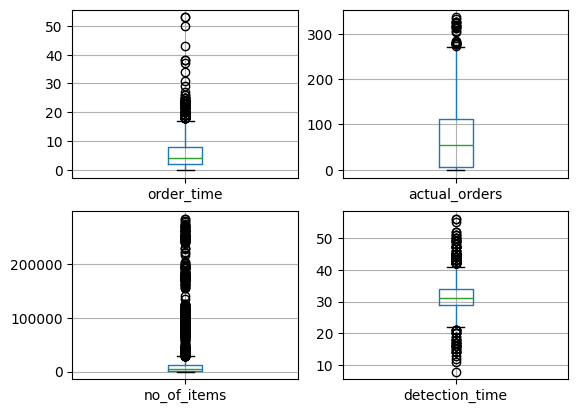

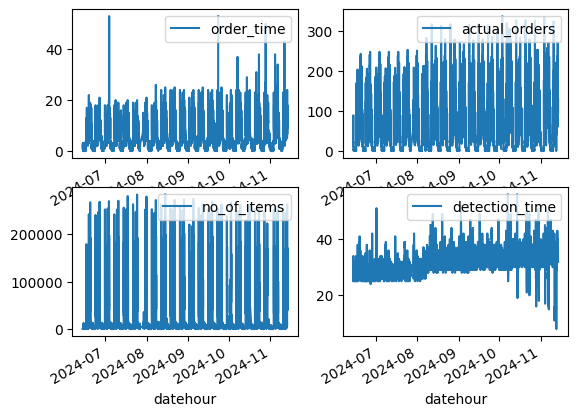

In [20]:
# plot box plots and line graphs again to compare after outlier removal
plt.subplot(2, 2, 1)
data.boxplot(column=['order_time'])

plt.subplot(2, 2, 2)
data.boxplot(column=['actual_orders'])

plt.subplot(2, 2, 3)
data.boxplot(column=['no_of_items'])

plt.subplot(2, 2, 4)
data.boxplot(column=['detection_time'])

plt.show()

plt.subplot(2, 2, 1)
data['order_time'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 2)
data['actual_orders'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 3)
data['no_of_items'].plot.line()
plt.legend(loc="upper right")

plt.subplot(2, 2, 4)
data['detection_time'].plot.line()
plt.legend(loc="upper right")

plt.show()

In [21]:
# dropping na values for detection and order time variables as assuming these are also outliers
data.dropna(subset=['order_time','detection_time'], inplace=True)

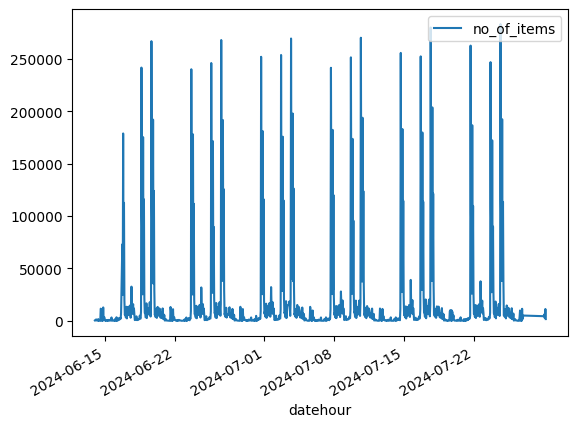

In [22]:
#shows weekly seasonality of 'no_of_items' column
data['no_of_items'][0:1000].plot.line()
plt.legend(loc="upper right")
plt.show()

p-Value:  6.570877806169453e-21


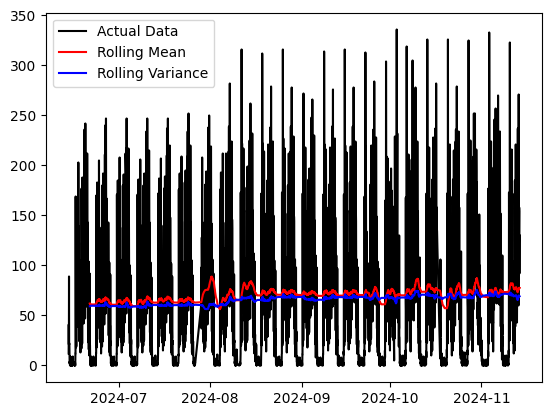

In [23]:
#Actual Orders Augmented Dickey Fuller Test - seems to suggest that this variable is stationary because the p-Value is less than 0.05 (also supported with the graph
#where the mena and variance don't seem to change overall.

Actual_Order_ADF_test_result = adfuller(data['actual_orders'])
print("p-Value: ", str(Actual_Order_ADF_test_result[1]))

rolling_mean = data['actual_orders'].rolling(window = 168).mean()
rolling_var = data['actual_orders'].rolling(window=168).std()

actual_data = plt.plot(data['actual_orders'], color = 'black', label = 'Actual Data')
mean = plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
stddev = plt.plot(rolling_var, color = 'blue', label = 'Rolling Variance')

plt.legend()
plt.show()

p-Value:  2.9344799110844165e-07


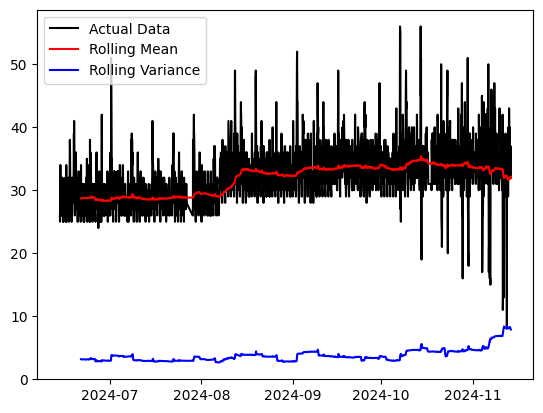

In [24]:
#Detecton Time Augmented Dickey Fuller Test - seems to suggest that this variable is stationary because the p-Value is less than 0.05 (also supported with the graph
#where the mena and variance don't seem to change overall.

Detection_Time_ADF_test_result = adfuller(data['detection_time'])
print("p-Value: ", str(Detection_Time_ADF_test_result[1]))

rolling_mean = data['detection_time'].rolling(window = 168).mean()
rolling_var = data['detection_time'].rolling(window=168).std()

actual_data = plt.plot(data['detection_time'], color = 'black', label = 'Actual Data')
mean = plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
stddev = plt.plot(rolling_var, color = 'blue', label = 'Rolling Variance')

plt.legend()
plt.show()

In [25]:
Order_Time_ADF_test_result = adfuller(data['order_time'])
print("p-Value: ", str(Order_Time_ADF_test_result[1]))

p-Value:  1.0906811136523762e-18


In [26]:
No_Of_Items_ADF_test_result = adfuller(data['no_of_items'])
print("p-Value: ", str(No_Of_Items_ADF_test_result[1]))

p-Value:  1.919724691879881e-20


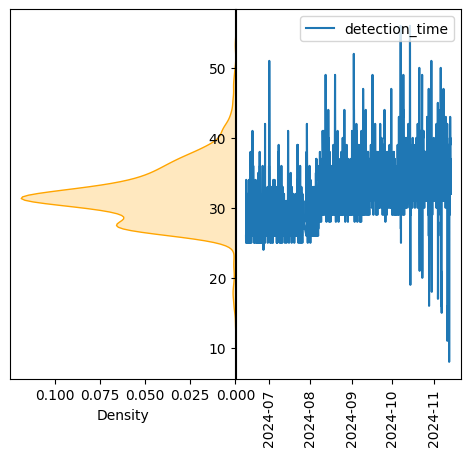

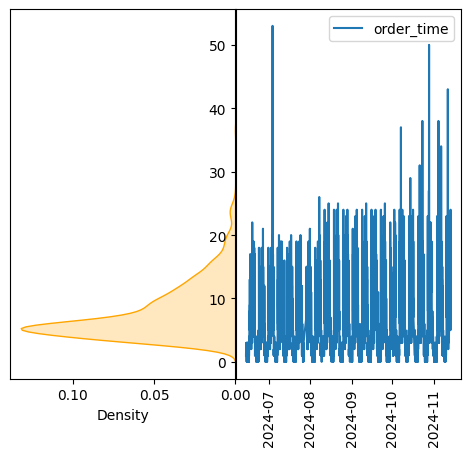

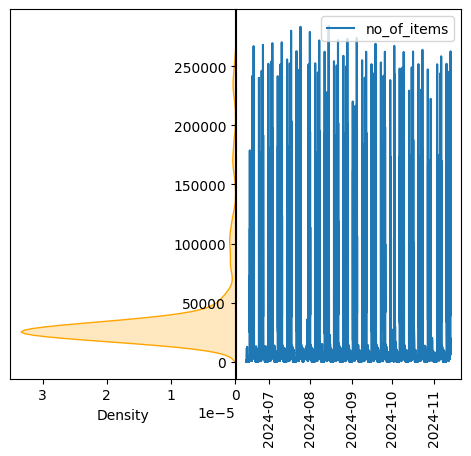

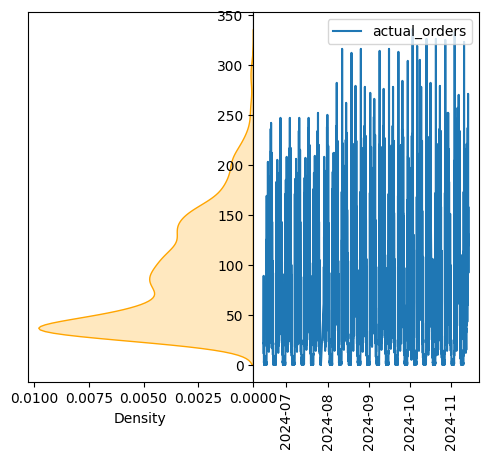

In [27]:
#all four variables seem to be stationary so plotting density plots on y-axis for each time series.

fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.invert_xaxis()
ax1.get_yaxis().set_visible(False)
box = ax1.get_position()
box.x0 = box.x0 + 0.07
box.x1 = box.x1 + 0.07
ax1.set_position(box)
sns.kdeplot(y=data['detection_time'], fill=True, color="orange" , ax=ax1)

detection_time_time_series, = ax2.plot(data['detection_time'], label=data['detection_time'].name)
ax2.legend(loc="upper right")
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.invert_xaxis()
ax1.get_yaxis().set_visible(False)
box = ax1.get_position()
box.x0 = box.x0 + 0.07
box.x1 = box.x1 + 0.07
ax1.set_position(box)
sns.kdeplot(y=data['order_time'], fill=True, color="orange" , ax=ax1)

detection_time_time_series, = ax2.plot(data['order_time'], label=data['order_time'].name)
ax2.legend(loc="upper right")
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.invert_xaxis()
ax1.get_yaxis().set_visible(False)
box = ax1.get_position()
box.x0 = box.x0 + 0.07
box.x1 = box.x1 + 0.07
ax1.set_position(box)
sns.kdeplot(y=data['no_of_items'], fill=True, color="orange" , ax=ax1)

detection_time_time_series, = ax2.plot(data['no_of_items'], label=data['no_of_items'].name)
ax2.legend(loc="upper right")
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.invert_xaxis()
ax1.get_yaxis().set_visible(False)
box = ax1.get_position()
box.x0 = box.x0 + 0.07
box.x1 = box.x1 + 0.07
ax1.set_position(box)
sns.kdeplot(y=data['actual_orders'], fill=True, color="orange" , ax=ax1)

detection_time_time_series, = ax2.plot(data['actual_orders'], label=data['actual_orders'].name)
ax2.legend(loc="upper right")
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

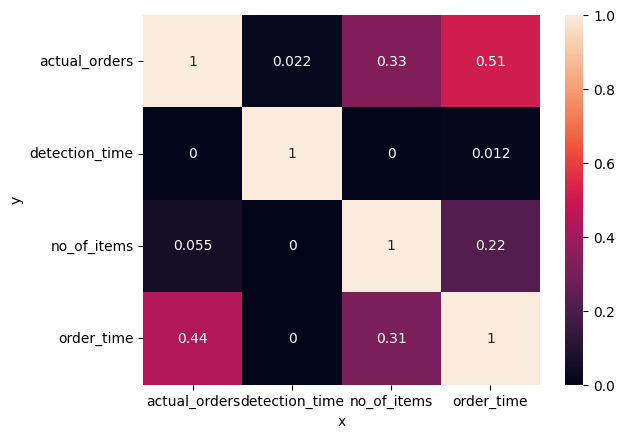

In [28]:
#predictive power score 1
datapps = pps.matrix(data)
sns.heatmap(datapps.pivot(index='y', columns='x', values='ppscore'), annot=True)
plt.show()

In [29]:
#distance correlation comparison against pearson correlation
print(dist_corr(data))
print(data.corr())

                detection_time  order_time  actual_orders  no_of_items
detection_time        1.000000    0.232091       0.220152     0.106448
order_time            0.232091    1.000000       0.800004     0.636633
actual_orders         0.220152    0.800004       1.000000     0.537322
no_of_items           0.106448    0.636633       0.537322     1.000000
                detection_time  order_time  actual_orders  no_of_items
detection_time        1.000000    0.152313       0.200747    -0.058397
order_time            0.152313    1.000000       0.767667     0.648853
actual_orders         0.200747    0.767667       1.000000     0.543129
no_of_items          -0.058397    0.648853       0.543129     1.000000


In [30]:
#maybe different periods have different distributions?
#check for outliers - but be conscious that certain variables may have an expected high variance. Can try to add more variables in future to try to predict such outliers.
#plot line graphs
#distributions of each variable
#univariate, bivariate, multivariate analysis - see https://www.geeksforgeeks.org/what-is-exploratory-data-analysis/
                                            # - see https://www.quora.com/What-should-I-do-if-I-have-very-little-correlation-between-my-all-feature-variable-and-target-variable-on-my-dataset
#Analyze each query from the BU AO Detection job - I am just analyzing the quantity of data and since the converted delete and insert and update
#statements would likely return same/similar it's not needed to analyze these statements right? If want to analyze, perhaps I can take a backup
#relevant production table(s) and point the SQL statements to the backups?

#imputed missing values for detection and order time variables with zero because I have assumed that a missing value for this variable means that there was no detection job run for that hour.

In [31]:
filepath2 = r'C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\AO Detection Time Forecasting\From_20250101_Altogether_Extract_No_Heatmap.csv'
data2 = pd.read_csv(filepath2, index_col='datehour')
data2.index = pd.to_datetime(data2.index,format='%d/%m/%Y %H:%M')
print(data2.shape)

(336, 8)


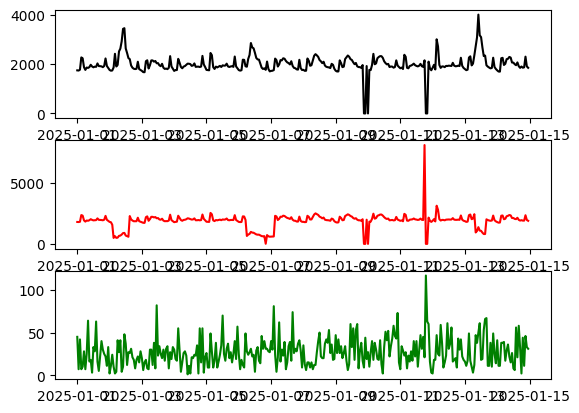

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(data2['exec_time_tot_ind'], color = 'black')
ax2.plot(data2['exec_time_main'], color = 'red')
ax3.plot(data2['load_obs_5min'], color = 'green')

plt.show()

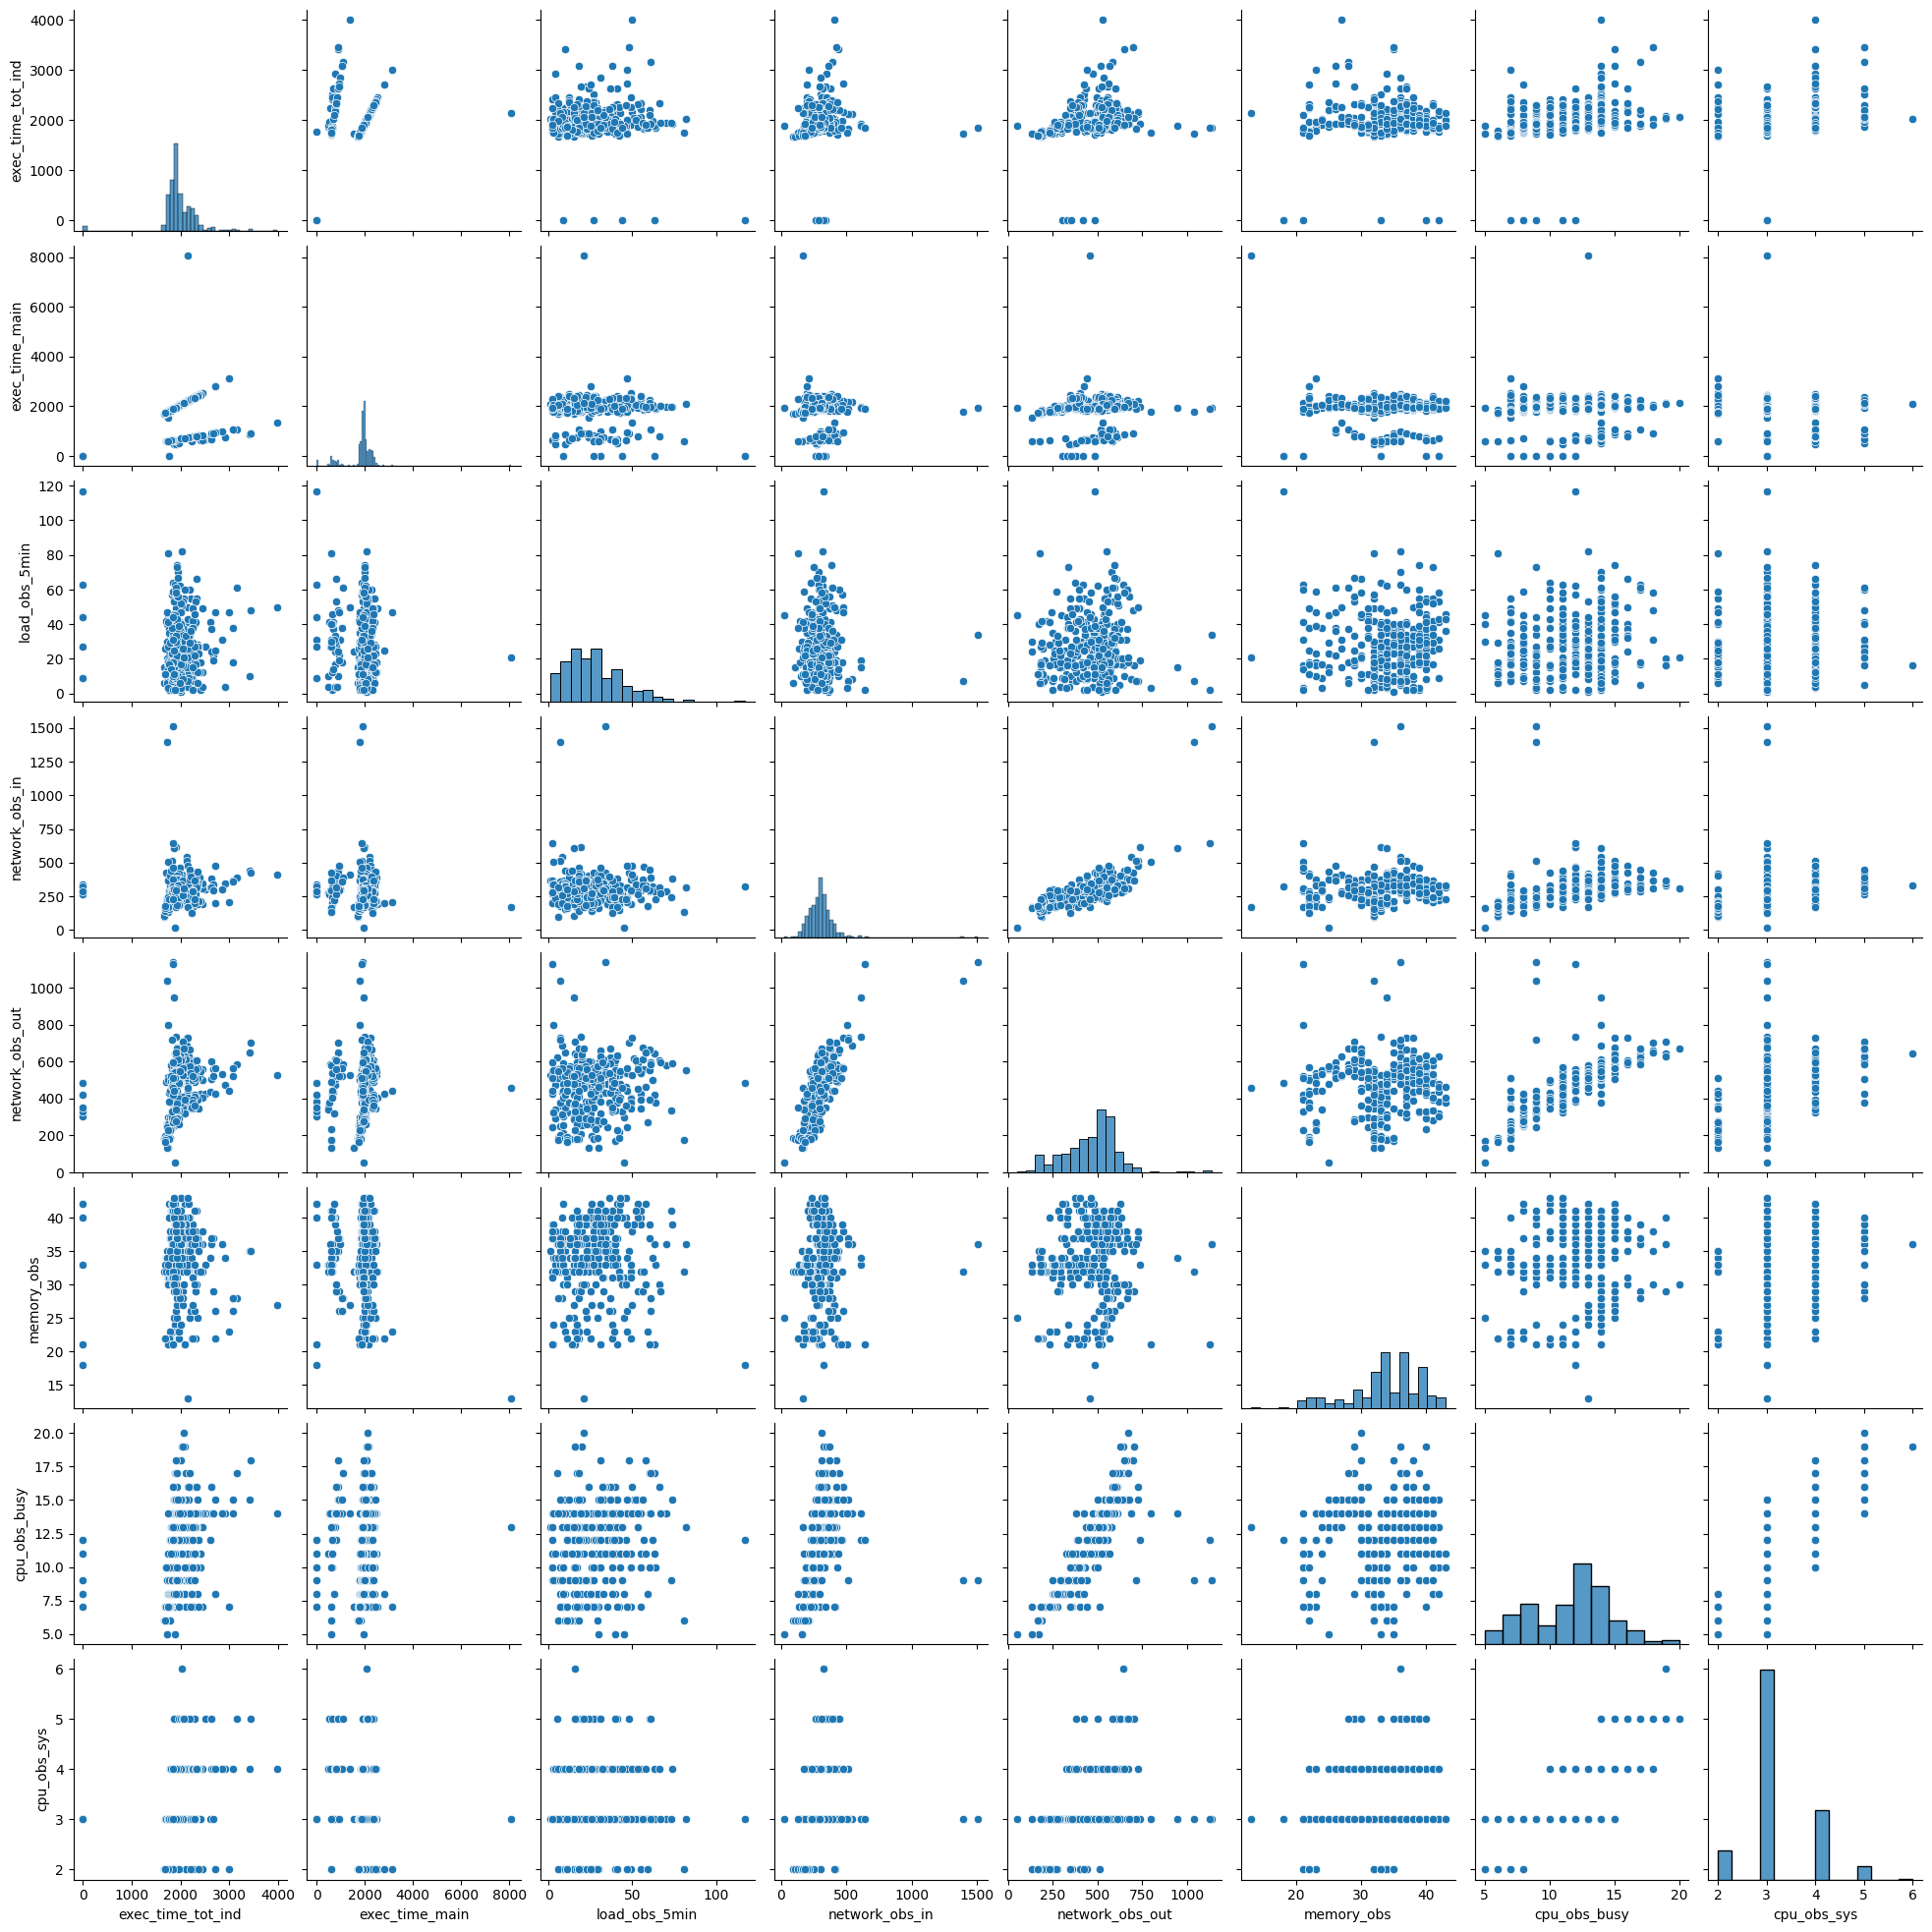

In [33]:
sns.pairplot(data2)

In [34]:
data2['exec_time_tot_ind_shift1'] = data2['exec_time_tot_ind'].shift(periods=1)
data2['exec_time_main_shift1'] = data2['exec_time_main'].shift(periods=1)
data2.drop(['2025-01-01 00:00:00'],inplace=True)
corr_matrix2 = data2.corr()
print(corr_matrix2)

                          exec_time_tot_ind  exec_time_main  load_obs_5min  \
exec_time_tot_ind                  1.000000        0.192870      -0.041884   
exec_time_main                     0.192870        1.000000      -0.100956   
load_obs_5min                     -0.041884       -0.100956       1.000000   
network_obs_in                     0.079953       -0.046190      -0.019853   
network_obs_out                    0.253529        0.097951       0.049861   
memory_obs                        -0.009984       -0.151805       0.026389   
cpu_obs_busy                       0.316363        0.060584       0.116276   
cpu_obs_sys                        0.281477       -0.095448       0.042186   
exec_time_tot_ind_shift1           0.594031       -0.054887      -0.005277   
exec_time_main_shift1             -0.199512        0.425872       0.065961   

                          network_obs_in  network_obs_out  memory_obs  \
exec_time_tot_ind               0.079953         0.253529   -0.00998

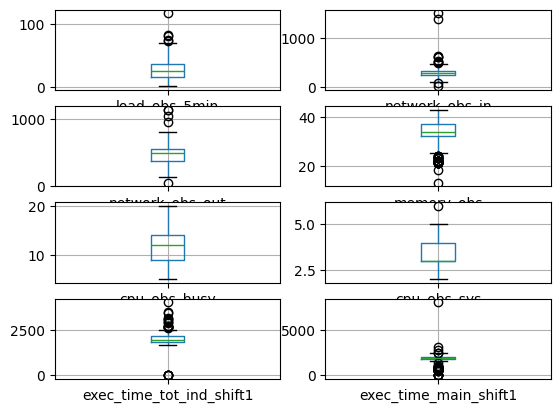

In [35]:
plt.subplot(4, 2, 1)
data2.boxplot(column=['load_obs_5min'])

plt.subplot(4, 2, 2)
data2.boxplot(column=['network_obs_in'])

plt.subplot(4, 2, 3)
data2.boxplot(column=['network_obs_out'])

plt.subplot(4, 2, 4)
data2.boxplot(column=['memory_obs'])

plt.subplot(4, 2, 5)
data2.boxplot(column=['cpu_obs_busy'])

plt.subplot(4, 2, 6)
data2.boxplot(column=['cpu_obs_sys'])

plt.subplot(4, 2, 7)
data2.boxplot(column=['exec_time_tot_ind_shift1'])

plt.subplot(4, 2, 8)
data2.boxplot(column=['exec_time_main_shift1'])

plt.show()

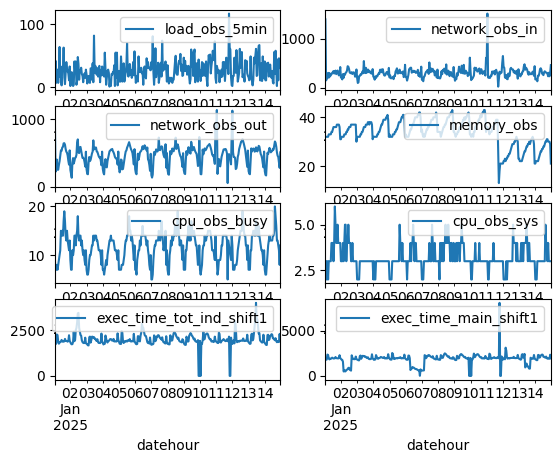

In [36]:
plt.subplot(4, 2, 1)
data2['load_obs_5min'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 2)
data2['network_obs_in'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 3)
data2['network_obs_out'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 4)
data2['memory_obs'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 5)
data2['cpu_obs_busy'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 6)
data2['cpu_obs_sys'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 7)
data2['exec_time_tot_ind_shift1'].plot.line()
plt.legend(loc="upper right")

plt.subplot(4, 2, 8)
data2['exec_time_main_shift1'].plot.line()
plt.legend(loc="upper right")

plt.show()

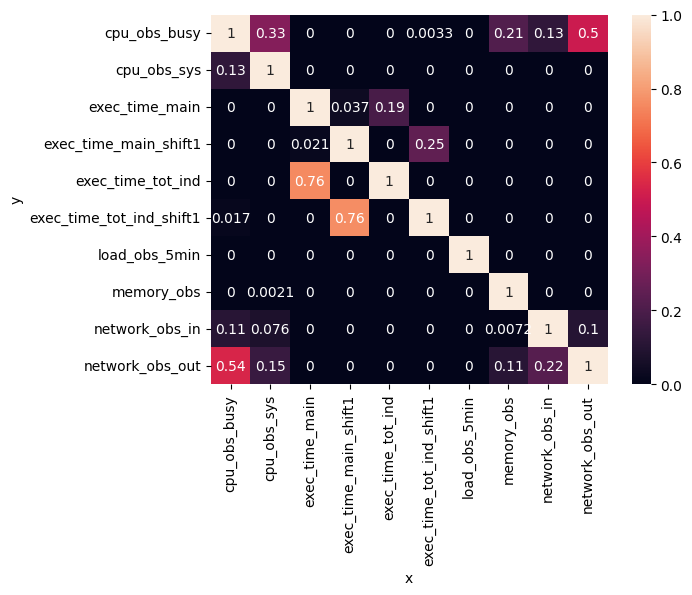

In [37]:
#predictive power score 2
datapps2 = pps.matrix(data2)
sns.heatmap(datapps2.pivot(index='y', columns='x', values='ppscore'), annot=True)
plt.show()

In [38]:
#distance correlation comparison against pearson correlation
print(dist_corr(data2))
print(data2.corr())

                          exec_time_tot_ind  exec_time_main  load_obs_5min  \
exec_time_tot_ind                  1.000000        0.579291       0.129492   
exec_time_main                     0.579291        1.000000       0.123646   
load_obs_5min                      0.129492        0.123646       1.000000   
network_obs_in                     0.233608        0.144203       0.101912   
network_obs_out                    0.396454        0.229276       0.122770   
memory_obs                         0.168040        0.132935       0.171404   
cpu_obs_busy                       0.388702        0.196927       0.135243   
cpu_obs_sys                        0.329985        0.199952       0.066988   
exec_time_tot_ind_shift1           0.602035        0.360689       0.096584   
exec_time_main_shift1              0.387378        0.772132       0.140328   

                          network_obs_in  network_obs_out  memory_obs  \
exec_time_tot_ind               0.233608         0.396454    0.16804

**Not removing potential outliers for 'data2' above until there is more data.**

In [39]:
filepath3 = r'C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\AO Detection Time Forecasting\From_20241209_Det_Time_n__All_Load_A34V_Rolling_Window_Maybe.csv'
data3 = pd.read_csv(filepath3, index_col='datehour')
data3.index = pd.to_datetime(data3.index,format='%d/%m/%Y %H:%M')
print(data3.shape)

(864, 10)


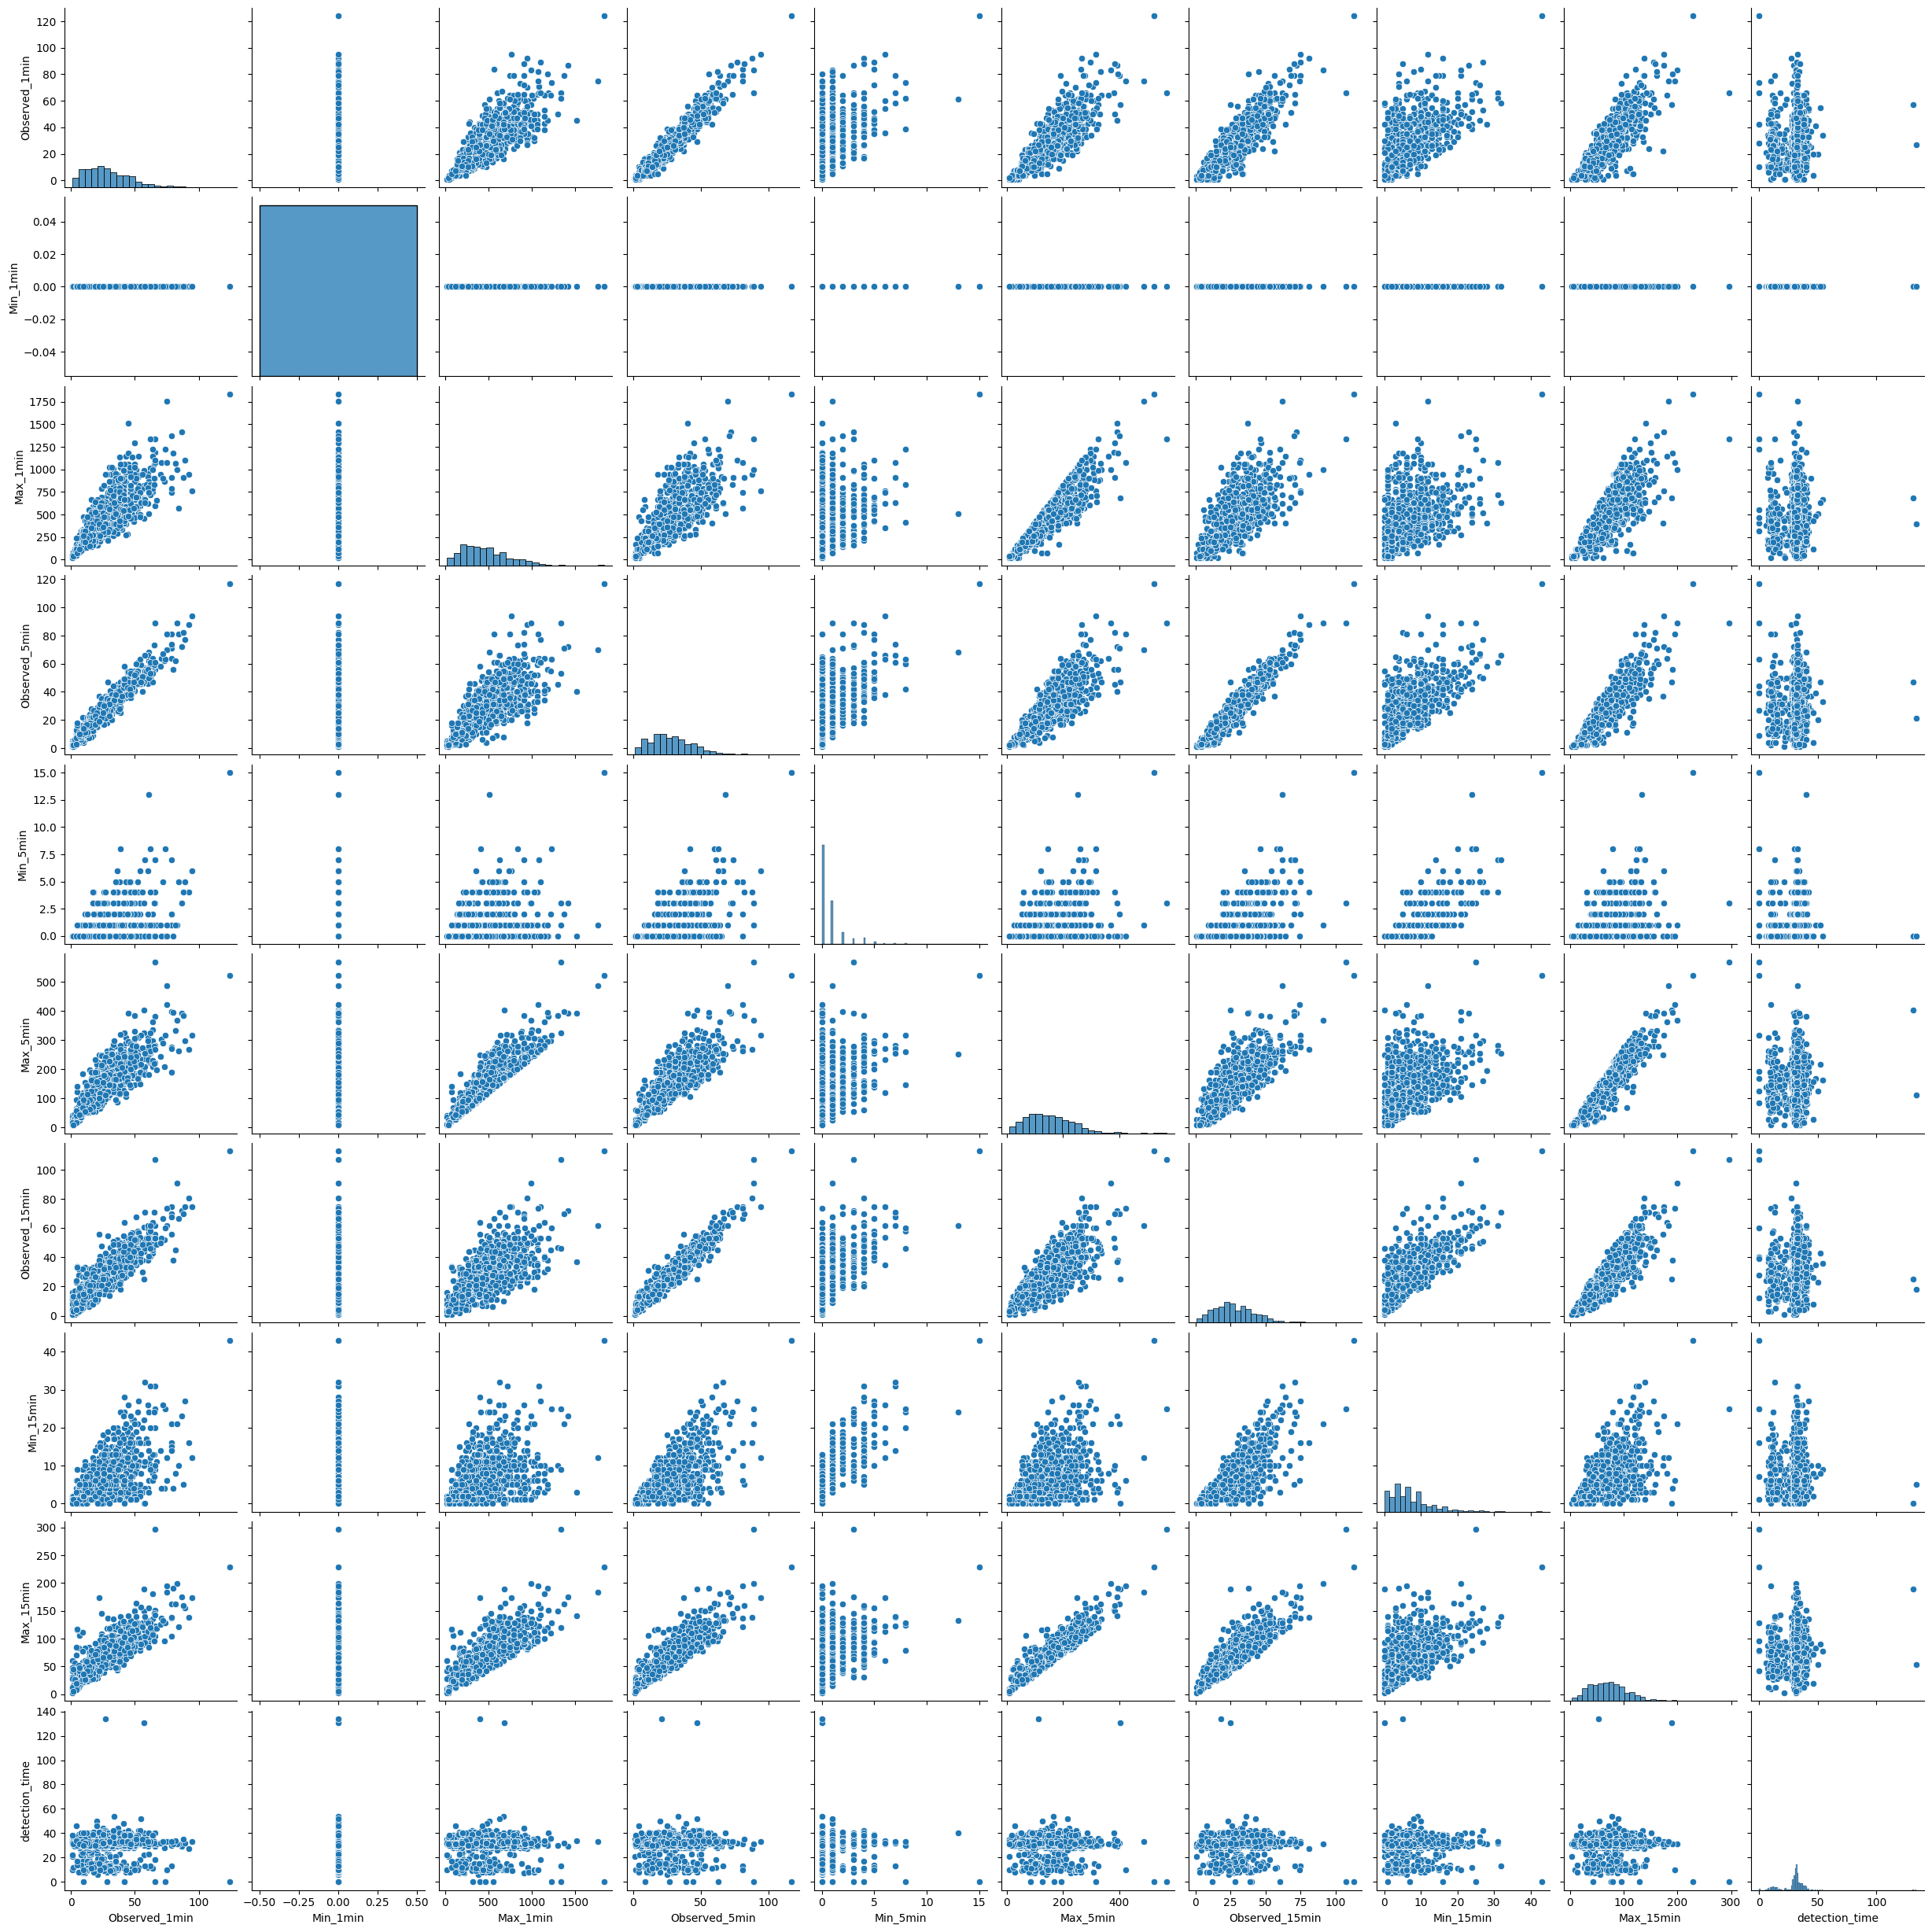

In [40]:
sns.pairplot(data3)

In [41]:
corr_matrix3 = data3.corr()
print(corr_matrix3)

                Observed_1min  Min_1min  Max_1min  Observed_5min  Min_5min  \
Observed_1min        1.000000       NaN  0.819236       0.963173  0.482001   
Min_1min                  NaN       NaN       NaN            NaN       NaN   
Max_1min             0.819236       NaN  1.000000       0.758105  0.278557   
Observed_5min        0.963173       NaN  0.758105       1.000000  0.533922   
Min_5min             0.482001       NaN  0.278557       0.533922  1.000000   
Max_5min             0.841538       NaN  0.904607       0.846321  0.327199   
Observed_15min       0.880888       NaN  0.693960       0.957163  0.562633   
Min_15min            0.573215       NaN  0.383658       0.646591  0.764236   
Max_15min            0.839970       NaN  0.798195       0.885068  0.382010   
detection_time      -0.003713       NaN -0.006601      -0.027782 -0.069599   

                Max_5min  Observed_15min  Min_15min  Max_15min  detection_time  
Observed_1min   0.841538        0.880888   0.573215   0.8399

In [42]:
data3['detection_time_shift1'] = data3['detection_time'].shift(periods=1)
data3.drop(['Min_1min'],axis=1,inplace=True)
data3.drop(['2024-12-09 00:00:00'],inplace=True)
corr_matrix3 = data3.corr()
print(corr_matrix3)

                       Observed_1min  Max_1min  Observed_5min  Min_5min  \
Observed_1min               1.000000  0.819243       0.963216  0.482057   
Max_1min                    0.819243  1.000000       0.758237  0.278672   
Observed_5min               0.963216  0.758237       1.000000  0.533922   
Min_5min                    0.482057  0.278672       0.533922  1.000000   
Max_5min                    0.841547  0.904579       0.846462  0.327320   
Observed_15min              0.880911  0.694046       0.957165  0.562642   
Min_15min                   0.573176  0.383520       0.646665  0.764367   
Max_15min                   0.839960  0.798162       0.885149  0.382093   
detection_time             -0.003969 -0.007133      -0.027759 -0.069502   
detection_time_shift1       0.056326  0.079771       0.060091  0.111291   

                       Max_5min  Observed_15min  Min_15min  Max_15min  \
Observed_1min          0.841547        0.880911   0.573176   0.839960   
Max_1min               0.904

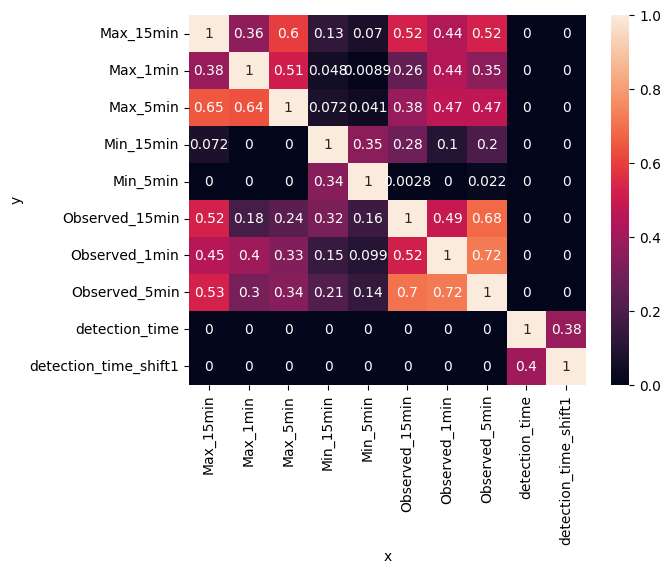

In [43]:
#predictive power score 3
datapps3 = pps.matrix(data3)
sns.heatmap(datapps3.pivot(index='y', columns='x', values='ppscore'), annot=True)
plt.show()

In [44]:
#distance correlation comparison against pearson correlation
print(dist_corr(data3))
print(data3.corr())

                       Observed_1min  Max_1min  Observed_5min  Min_5min  \
Observed_1min               1.000000  0.805198       0.952637  0.438894   
Max_1min                    0.805198  1.000000       0.741751  0.256890   
Observed_5min               0.952637  0.741751       1.000000  0.487992   
Min_5min                    0.438894  0.256890       0.487992  1.000000   
Max_5min                    0.823033  0.890180       0.824759  0.298714   
Observed_15min              0.852885  0.666296       0.939072  0.525429   
Min_15min                   0.533719  0.356057       0.604874  0.754815   
Max_15min                   0.827290  0.788391       0.869680  0.360152   
detection_time              0.059688  0.066690       0.062005  0.052651   
detection_time_shift1       0.068069  0.070310       0.081929  0.068919   

                       Max_5min  Observed_15min  Min_15min  Max_15min  \
Observed_1min          0.823033        0.852885   0.533719   0.827290   
Max_1min               0.890

In [45]:
filepath4 = r'C:\Users\1026664\OneDrive - Blue Yonder\Documents\Machine Learning\AO Detection Time Forecasting\APE_Jobs_by_hour_on_A34V_vs_Det_Time.csv'
data4 = pd.read_csv(filepath4, index_col='datehour')
data4.index = pd.to_datetime(data4.index,format='%d/%m/%Y %H:%M')
print(data4.shape)

(360, 2)


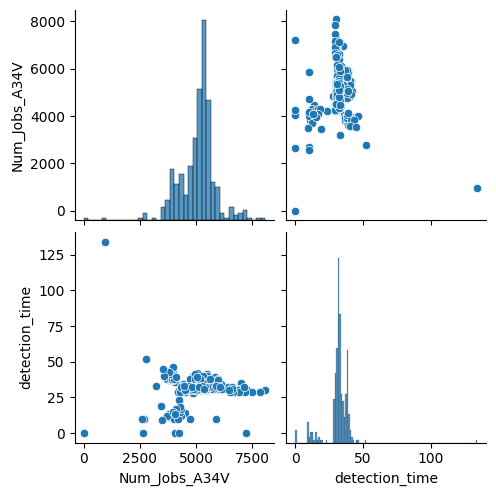

In [46]:
sns.pairplot(data4)

In [47]:
corr_matrix4 = data4.corr()
print(corr_matrix4)

                Num_Jobs_A34V  detection_time
Num_Jobs_A34V        1.000000        0.057407
detection_time       0.057407        1.000000


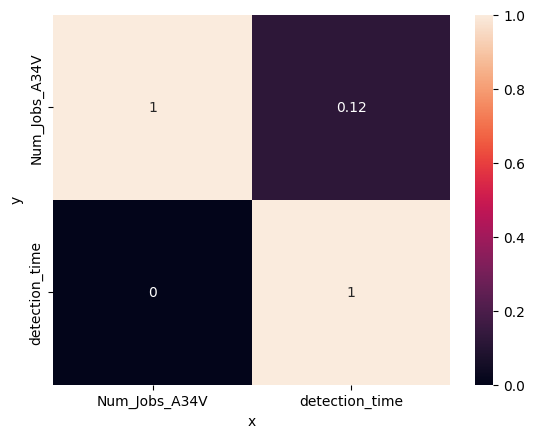

In [48]:
#predictive power score 4
datapps4 = pps.matrix(data4)
sns.heatmap(datapps4.pivot(index='y', columns='x', values='ppscore'), annot=True)
plt.show()

In [49]:
#This comparison between distance correlation and pearson correlation coefficient for data4 seems to suggest a non-linear relationship
print(dist_corr(data4))
print(data4.corr())

                Num_Jobs_A34V  detection_time
Num_Jobs_A34V        1.000000        0.470218
detection_time       0.470218        1.000000
                Num_Jobs_A34V  detection_time
Num_Jobs_A34V        1.000000        0.057407
detection_time       0.057407        1.000000
